In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 781ms/step - loss: 0.5624
Average validation loss: 0.6529606580734253
4/4 [==============================] - 8s 797ms/step - loss: 0.5624 - val_loss: 0.6530
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 805ms/step - loss: 0.4257 - val_loss: 0.6530
Average validation loss: 0.38029447197914124
4/4 [==============================] - 11s 818ms/step - loss: 0.4257 - val_loss: 0.5166
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 844ms/step - loss: 0.3487 - val_loss: 0.5166
Average validation loss: 0.38298264145851135
4/4 [==============================] - 15s 856ms/step - loss: 0.3487 - val_loss: 0.4721
Epoch 4/10
4/4 [==============================] - 18s 755ms

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 792ms/step - loss: 0.0278
Average validation loss: 6.10554939939334e-10
8/8 [==============================] - 6s 805ms/step - loss: 0.0278 - val_loss: 6.1055e-10
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 827ms/step - loss: 0.0271 - val_loss: 6.1055e-10
Average validation loss: 3.1320719889177395e-11
8/8 [==============================] - 13s 839ms/step - loss: 0.0271 - val_loss: 3.2094e-10
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 20s 782ms/step - loss: 0.0270 - val_loss: 3.2094e-10
Average validation loss: 4.396307986098691e-06
8/8 [==============================] - 20s 797ms/step - loss: 0.0270 - val_loss: 1.4656e-06
Epoch 4/10
8/8 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 792ms/step - loss: 0.0351
Average validation loss: 0.03708989981290264
12/12 [==============================] - 10s 806ms/step - loss: 0.0351 - val_loss: 0.0371
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 20s 805ms/step - loss: 0.0358 - val_loss: 0.0371
Average validation loss: 0.4968590422678882
12/12 [==============================] - 20s 817ms/step - loss: 0.0358 - val_loss: 0.2670
Epoch 3/10
12/12 [==============================] - 30s 859ms/step - loss: 0.0370 - val_loss: 0.2670
Average validation loss: 0.33793089788916103
12/12 [==============================] - 30s 872ms/step - loss: 0.0370 - val_loss: 0.2906
Epoch 4/10
12/12 [==============================] - 40s 837ms/step - loss: 0.0368 - val_loss: 0.2906
Average validation loss: 0.14273331562678018
12/12 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 811ms/step - loss: 0.0359
Average validation loss: 0.05246467546385247
16/16 [==============================] - 13s 823ms/step - loss: 0.0359 - val_loss: 0.0525
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 790ms/step - loss: 0.0357 - val_loss: 0.0525
Average validation loss: 0.04063511790445773
16/16 [==============================] - 26s 803ms/step - loss: 0.0357 - val_loss: 0.0465
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 39s 809ms/step - loss: 0.0353 - val_loss: 0.0465
Average validation loss: 0.11786808649527813
16/16 [==============================] - 39s 823ms/step - loss: 0.0353 - val_loss: 0.0703
Epoch 4/10
16/16 [========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 727ms/step - loss: 0.0219
Average validation loss: 0.16937395034693167
20/20 [==============================] - 15s 739ms/step - loss: 0.0219 - val_loss: 0.1694
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 723ms/step - loss: 0.0225 - val_loss: 0.1694
Average validation loss: 0.04596372526139021
20/20 [==============================] - 30s 735ms/step - loss: 0.0225 - val_loss: 0.1077
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 717ms/step - loss: 0.0217 - val_loss: 0.1077
Average validation loss: 0.03039641948416829
20/20 [==============================] - 44s 729ms/step - loss: 0.0217 - val_loss: 0.0819
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 736ms/step - loss: 0.0188
Average validation loss: 0.05659285746514797
24/24 [==============================] - 18s 747ms/step - loss: 0.0188 - val_loss: 0.0566
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 719ms/step - loss: 0.0183 - val_loss: 0.0566
Average validation loss: 0.039335571229457855
24/24 [==============================] - 36s 730ms/step - loss: 0.0183 - val_loss: 0.0480
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 726ms/step - loss: 0.0178 - val_loss: 0.0480
Average validation loss: 0.02766574981311957
24/24 [==============================] - 53s 738ms/step - loss: 0.0178 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Des

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 741ms/step - loss: 0.0235
Average validation loss: 0.03923825807869434
40/40 [==============================] - 30s 753ms/step - loss: 0.0235 - val_loss: 0.0392
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 722ms/step - loss: 0.0222 - val_loss: 0.0392
Average validation loss: 0.027785799279809
40/40 [==============================] - 60s 735ms/step - loss: 0.0222 - val_loss: 0.0335
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 90s 746ms/step - loss: 0.0215 - val_loss: 0.0335
Average validation loss: 0.03204888179898262
40/40 [==============================] - 90s 758ms/step - loss: 0.0215 - val_loss: 0.0330
Epoch 4/10
40/40 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 727ms/step - loss: 0.0196
Average validation loss: 0.012850095167872647
48/48 [==============================] - 35s 739ms/step - loss: 0.0196 - val_loss: 0.0129
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 741ms/step - loss: 0.0176 - val_loss: 0.0129
Average validation loss: 0.01502242098407199
48/48 [==============================] - 72s 753ms/step - loss: 0.0176 - val_loss: 0.0139
Epoch 3/10
48/48 [==============================] - 106s 718ms/step - loss: 0.0157 - val_loss: 0.0139
Average validation loss: 0.013657130667221887
48/48 [==============================] - 107s 730ms/step - loss: 0.0157 - val_loss: 0.0138
Epoch 4/10
48/48 [==============================] - 142s 730ms/step - loss: 0.0145 - val_loss: 0.0138
Average validation loss: 0.0145541853459387
48/48 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 718ms/step - loss: 0.0184
Average validation loss: 0.016342879841049904
56/56 [==============================] - 41s 730ms/step - loss: 0.0184 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 717ms/step - loss: 0.0154 - val_loss: 0.0163
Average validation loss: 0.018177291549954382
56/56 [==============================] - 82s 728ms/step - loss: 0.0154 - val_loss: 0.0173
Epoch 3/10
56/56 [==============================] - 122s 720ms/step - loss: 0.0134 - val_loss: 0.0173
Average validation loss: 0.017110652859657245
56/56 [==============================] - 123s 732ms/step - loss: 0.0134 - val_loss: 0.0172
Epoch 4/10
56/56 [==============================] - 163s 716ms/step - loss: 0.0125 - val_loss: 0.0172
Average validation loss: 0.017880208118320442
56/56 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 730ms/step - loss: 0.0129
Average validation loss: 0.009979891372495331
64/64 [==============================] - 47s 741ms/step - loss: 0.0129 - val_loss: 0.0100
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 716ms/step - loss: 0.0111 - val_loss: 0.0100
Average validation loss: 0.020059869374563277
64/64 [==============================] - 94s 727ms/step - loss: 0.0111 - val_loss: 0.0150
Epoch 3/10
64/64 [==============================] - 140s 713ms/step - loss: 0.0102 - val_loss: 0.0150
Average validation loss: 0.01992477305475404
64/64 [==============================] - 140s 725ms/step - loss: 0.0102 - val_loss: 0.0167
Epoch 4/10
64/64 [==============================] - 186s 719ms/step - loss: 0.0093 - val_loss: 0.0167
Average validation loss: 0.016611556951829698
64/64 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 714ms/step - loss: 0.0121
Average validation loss: 0.013406092637322016
72/72 [==============================] - 52s 725ms/step - loss: 0.0121 - val_loss: 0.0134
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 722ms/step - loss: 0.0101 - val_loss: 0.0134
Average validation loss: 0.011462600604217086
72/72 [==============================] - 105s 733ms/step - loss: 0.0101 - val_loss: 0.0124
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 727ms/step - loss: 0.0091 - val_loss: 0.0124
Average validation loss: 0.014559472212567925
72/72 [==============================] - 158s 738ms/step - loss: 0.0091 - val_loss: 0.0131
Epoch 4/10
72/72 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 715ms/step - loss: 0.0108
Average validation loss: 0.007592308742459863
80/80 [==============================] - 58s 726ms/step - loss: 0.0108 - val_loss: 0.0076
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 717ms/step - loss: 0.0091 - val_loss: 0.0076
Average validation loss: 0.016118478355929257
80/80 [==============================] - 117s 729ms/step - loss: 0.0091 - val_loss: 0.0119
Epoch 3/10
80/80 [==============================] - 174s 718ms/step - loss: 0.0081 - val_loss: 0.0119
Average validation loss: 0.027193886251188813
80/80 [==============================] - 175s 730ms/step - loss: 0.0081 - val_loss: 0.0170
Epoch 4/10
80/80 [==============================] - 233s 719ms/step - loss: 0.0073 - val_loss: 0.0170
Average validation loss: 0.011673121596686542
80/80 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 717ms/step - loss: 0.0145
Average validation loss: 0.025677059499988292
96/96 [==============================] - 70s 728ms/step - loss: 0.0145 - val_loss: 0.0257
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 713ms/step - loss: 0.0123 - val_loss: 0.0257
Average validation loss: 0.021881920409214217
96/96 [==============================] - 140s 724ms/step - loss: 0.0123 - val_loss: 0.0238
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 208s 714ms/step - loss: 0.0108 - val_loss: 0.0238
Average validation loss: 0.030571854979257296
96/96 [==============================] - 209s 726ms/step - loss: 0.0108 - val_loss: 0.0260
Epoch 4/10
96/96 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 715ms/step - loss: 0.0107
Average validation loss: 0.012579538436451305
120/120 [==============================] - 87s 727ms/step - loss: 0.0107 - val_loss: 0.0126
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 173s 714ms/step - loss: 0.0090 - val_loss: 0.0126
Average validation loss: 0.007986972440266981
120/120 [==============================] - 174s 726ms/step - loss: 0.0090 - val_loss: 0.0103
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 720ms/step - loss: 0.0079 - val_loss: 0.0103
Average validation loss: 0.015841613938876738
120/120 [==============================] - 262s 731ms/step - loss: 0.0079 - val_loss: 0.0121
Epoch 4/10
120/120 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 718ms/step - loss: 0.0093
Average validation loss: 0.008194206188717443
144/144 [==============================] - 105s 729ms/step - loss: 0.0093 - val_loss: 0.0082
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 718ms/step - loss: 0.0076 - val_loss: 0.0082
Average validation loss: 0.008994204645407282
144/144 [==============================] - 210s 729ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 3/10
144/144 [==============================] - 314s 720ms/step - loss: 0.0068 - val_loss: 0.0086
Average validation loss: 0.00977866866446675
144/144 [==============================] - 315s 731ms/step - loss: 0.0068 - val_loss: 0.0090
Epoch 4/10
144/144 [==============================] - 418s 713ms/step - loss: 0.0064 - val_loss: 0.0090
Average validation loss: 0.010810192223762746
144/144 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 722ms/step - loss: 0.0065
Average validation loss: 0.006118091540550985
160/160 [==============================] - 117s 733ms/step - loss: 0.0065 - val_loss: 0.0061
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 716ms/step - loss: 0.0055 - val_loss: 0.0061
Average validation loss: 0.007570824585720714
160/160 [==============================] - 234s 728ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 3/10
160/160 [==============================] - 349s 717ms/step - loss: 0.0048 - val_loss: 0.0068
Average validation loss: 0.007329019292725991
160/160 [==============================] - 350s 728ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 4/10
160/160 [==============================] - 466s 719ms/step - loss: 0.0046 - val_loss: 0.0070
Average validation loss: 0.00631720323910222
160/160 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0130
Average validation loss: 0.007967435086611659
200/200 [==============================] - 146s 731ms/step - loss: 0.0130 - val_loss: 0.0080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 716ms/step - loss: 0.0104 - val_loss: 0.0080
Average validation loss: 0.009032030415255576
200/200 [==============================] - 292s 728ms/step - loss: 0.0104 - val_loss: 0.0085
Epoch 3/10
200/200 [==============================] - 435s 714ms/step - loss: 0.0087 - val_loss: 0.0085
Average validation loss: 0.01364975243108347
200/200 [==============================] - 437s 726ms/step - loss: 0.0087 - val_loss: 0.0102
Epoch 4/10
200/200 [==============================] - 580s 714ms/step - loss: 0.0077 - val_loss: 0.0102
Average validation loss: 0.01052335508284159
200/200 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:22 - loss: 0.0113

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 721ms/step - loss: 0.0078
Average validation loss: 0.016340528491036822
240/240 [==============================] - 176s 732ms/step - loss: 0.0078 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 712ms/step - loss: 0.0064 - val_loss: 0.0163
Average validation loss: 0.01397547212122466
240/240 [==============================] - 350s 724ms/step - loss: 0.0064 - val_loss: 0.0152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 521s 714ms/step - loss: 0.0055 - val_loss: 0.0152
Average validation loss: 0.01238728777407753
240/240 [==============================] - 524s 726ms/step - loss: 0.0055 - val_loss: 0.0142
Saved model weights t

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.07372839639514174, 0.10978160457212352, 0.2135861742500684, 0.19175609887878817, 0.060151499681403375, 0.03730574527119169, 0.024168963478081288, 0.01511393259616769, 0.011708158909984827, 0.010525147908169205, 0.010113394645982427, 0.008799368619879362, 0.013861809007547108, 0.007779844123341421, 0.009231406225764899, 0.005819806356738569, 0.0076044825380849265, 0.006789315723389156]
std_val_losses =  [0.13857847532661055, 0.1133581494205414, 0.18055631578249973, 0.19240726343782394, 0.0505852219069645, 0.028524129548131, 0.015274667843260004, 0.007623501930820625, 0.006184428625815943, 0.003938274444404855, 0.0048293081214536215, 0.004875458070327736, 0.013962867078689682, 0.003735733669364551, 0.01926821709289087, 0.002579708591024716, 0.004813518216752942, 0.004416066966956122]


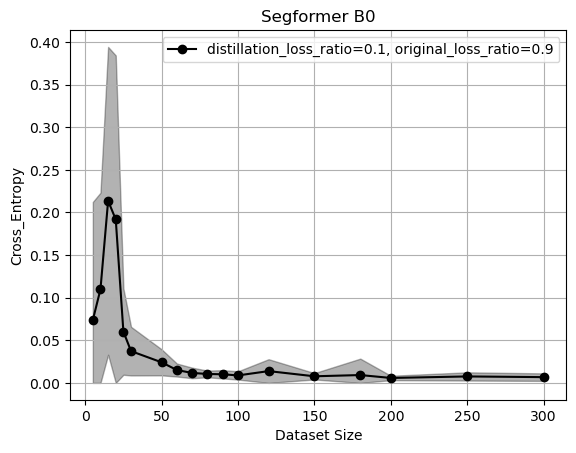

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()